# 1. Preparación de Entorno. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from pmdarima import auto_arima
%pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import ruptures as rpt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import joblib

Note: you may need to restart the kernel to use updated packages.


# 2. Carga de Datos. 

## Acuíferos. 

In [2]:
# Load the aquifer hydrology data
df_aquifers = pd.read_csv("../data/processed/aquifers/aquifer_hydrology_data_clean.csv")
df_aquifers.head()

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_80943/7009082.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_aquifers = pd.read_csv("../data/processed/aquifers/aquifer_hydrology_data_clean.csv")


,Date,was_nan,Value,Medition_Types,Location
0,1999-01-01,1,0.0,1,1
1,2000-01-01,1,0.0,1,1
2,2001-01-01,1,0.0,1,1
3,2002-01-01,1,0.0,1,1
4,2003-01-01,1,0.0,1,1


In [3]:
# Assume df_aquifers is your DataFrame
# Make sure the 'Date' column is a datetime type
df_aquifers['Date'] = pd.to_datetime(df_aquifers['Date'])

# Find the data for the year 1974
year_to_find = 2020  # Use an integer, not a string, for the comparison

# Create a boolean mask to filter the DataFrame
matching_data = df_aquifers[df_aquifers['Date'].dt.year == year_to_find]

print(f"Number of rows found for the year {year_to_find}: {len(matching_data)}")
print(matching_data.head())

Number of rows found for the year 2020: 182
          Date  was_nan  Value  Medition_Types  Location
21  2020-01-01        1    0.0               1         1
43  2020-02-01        0   11.6               1         1
65  2020-03-01        0   57.4               1         1
88  2020-04-01        1    0.0               1         1
111 2020-05-01        0    2.0               1         1


# 3. Definir Features (X) y Variable Target (Y). 

Para definir las variables features y la variable target, se considerarán los datos que nos son útiles para visualizar el nivel de agua según la fecha de cada cuerpo de agua, en este caso __"Value"__ es la variable target, mientras que el resto de las variables se considerarán variables feature.

# 4. Dividir data en train y test. 

In [4]:
import pandas as pd

def split_time_series_by_percentage(df, split_percentage):
    """
    Splits a time series DataFrame into training and testing sets
    based on a specified percentage. The DataFrame must be ordered chronologically.

    Args:
        df (pd.DataFrame): The input time series DataFrame.
        split_percentage (float): The percentage of data to use for the training set (e.g., 0.8 for 80%).

    Returns:
        tuple: A tuple containing the training and testing DataFrames (train_df, test_df).
    """
    if not 0 < split_percentage < 1:
        raise ValueError("split_percentage must be between 0 and 1.")

    split_point = int(len(df) * split_percentage)
    
    train_df = df.iloc[:split_point]
    test_df = df.iloc[split_point:]
    
    return train_df, test_df

In [5]:
# Split the aquifer data into training and testing sets
train_data_aquifers, test_data_aquifers = split_time_series_by_percentage(df_aquifers, 0.8)

# 5. Análisis de Series de Tiempo. 

In [6]:
train_data_aquifers['Date'] = pd.to_datetime(train_data_aquifers['Date'], errors='coerce')

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_80943/2953720666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_aquifers['Date'] = pd.to_datetime(train_data_aquifers['Date'], errors='coerce')


In [7]:
train_data_aquifers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273974 entries, 0 to 273973
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            8154 non-null    datetime64[ns]
 1   was_nan         273974 non-null  int64         
 2   Value           273974 non-null  float64       
 3   Medition_Types  273974 non-null  int64         
 4   Location        273974 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 10.5 MB


In [8]:
train_data_aquifers['Date'] = train_data_aquifers['Date'].dt.date

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_80943/383748217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_aquifers['Date'] = train_data_aquifers['Date'].dt.date


Punto de quiebre detectado en el índice: 610, fecha: 2014-10-15 00:00:00
Punto de quiebre detectado en el índice: 620, fecha: 2015-01-11 00:00:00
Punto de quiebre detectado en el índice: 800, fecha: 2020-01-25 00:00:00
Punto de quiebre detectado en el índice: 805, fecha: 2020-03-13 00:00:00


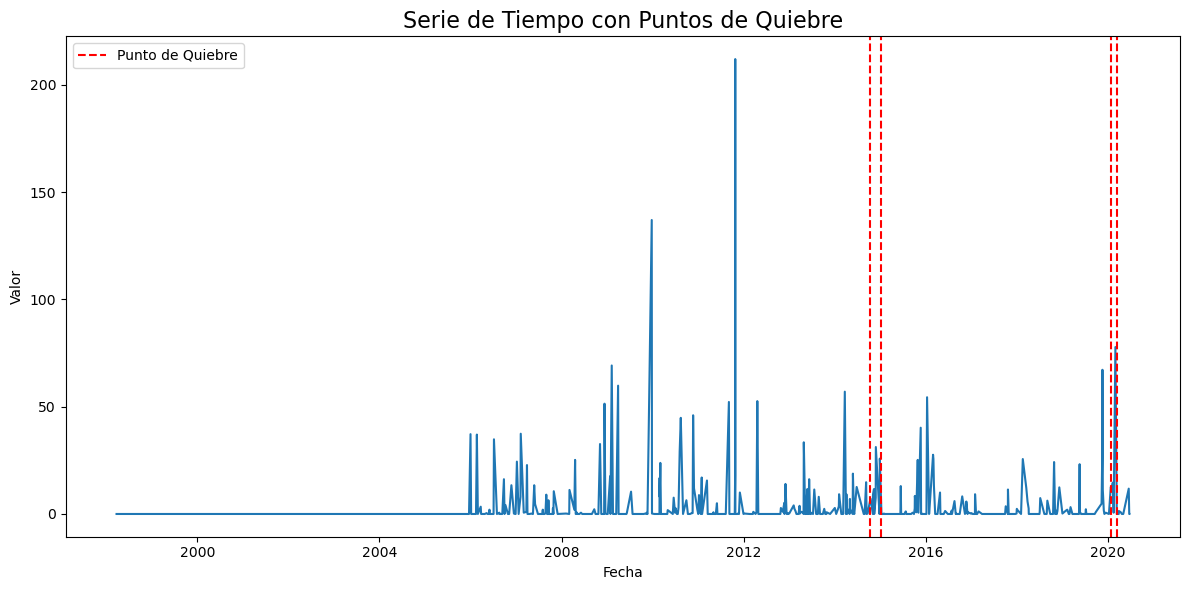

In [9]:
df = train_data_aquifers.copy()

# Paso 1: Limpieza y preparación del DataFrame.
# Asegúrate de que la columna de fechas esté en el formato correcto
df['Date'] = pd.to_datetime(df['Date'])
# Elimina filas con valores de fecha no válidos (NaT)
df.dropna(subset=['Date'], inplace=True)
# Ordena el DataFrame por la columna de fechas
df.sort_values(by='Date', inplace=True)
# Establece la columna de fechas como el índice
df.set_index('Date', inplace=True)

# Paso 2: Muestreo y limpieza de valores nulos o infinitos.
# Esto es para que el kernel no se bloquee con datos grandes
sample_size = 0.1  # 10% de tus datos
df_sampled = df.sample(frac=sample_size, random_state=42)
# Reordena el DataFrame después del muestreo para el gráfico
df_sampled.sort_index(inplace=True)
# Limpia los datos de la muestra antes de la detección
df_sampled = df_sampled.replace([np.inf, -np.inf], np.nan).dropna()

# Paso 3: Escalar los datos para la detección de quiebres.
values_original = df_sampled['Value'].values.reshape(-1, 1)
scaler = StandardScaler()
values_scaled = scaler.fit_transform(values_original)

# Paso 4: Detección de puntos de quiebre.
# Usa BinSeg, que es más rápido y robusto para datos grandes.
# Aquí le decimos que busque 1 punto de quiebre. Puedes ajustar este valor. 
algo = rpt.Pelt(model="l1").fit(values_scaled)
result = algo.predict(pen=1)

# Paso 5: Graficar la serie de tiempo con los puntos de quiebre.
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_sampled.index, values_original)
ax.set_title('Serie de Tiempo con Puntos de Quiebre', fontsize=16)
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')

for cp in result[:-1]:
    ax.axvline(x=df_sampled.index[cp], color='red', linestyle='--', label='Punto de Quiebre' if cp == result[0] else "")
    print(f"Punto de quiebre detectado en el índice: {cp}, fecha: {df_sampled.index[cp]}")

plt.legend()
plt.tight_layout()
plt.show()

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_80943/3431958062.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').mean()
/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


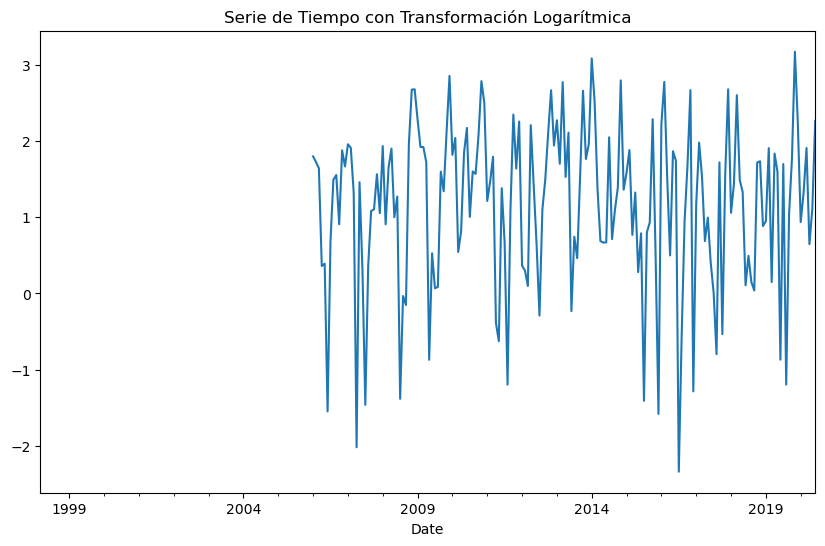

In [10]:
# --- 2. Estabilizar la Varianza (Transformación Logarítmica) ---
df = df.resample('M').mean()
df['log_value'] = np.log(df['Value'])
df['log_value'].plot(title='Serie de Tiempo con Transformación Logarítmica', figsize=(10, 6))
plt.show()

In [11]:
df['log_value'].unique()

array([       -inf,  1.79605132,  1.7227666 ,  1.64118661,  0.36000273,
        0.39029689, -1.54489939,  0.68342263,  1.49181615,  1.5518088 ,
        0.90721744,  1.87589635,  1.66465897,  1.95508453,  1.9095425 ,
        1.32132564, -2.01490302,  1.45786455,  0.32690279, -1.45990618,
        0.36822093,  1.08067459,  1.10290414,  1.56304487,  1.05239945,
        1.93105379,  0.90658865,  1.64741716,  1.89811949,  0.99920772,
        1.26976054, -1.37986347, -0.03278982, -0.15082289,  1.95050786,
        2.67092507,  2.67570472,  2.28106486,  1.91902125,  1.91881835,
        1.72038281, -0.86903785,  0.52669897,  0.06856267,  0.0864736 ,
        1.59601489,  1.34008152,  2.12026354,  2.85089295,  1.81723855,
        2.03750285,  0.54382354,  0.8124106 ,  1.83901235,  2.16867268,
        1.00394706,  1.59906168,  1.56722606,  2.07296903,  2.78253905,
        2.49613371,  1.21232492,  1.46523756,  1.79283416, -0.38566248,
       -0.62458451,  1.37960537,  0.66035736, -1.19327752,  1.08

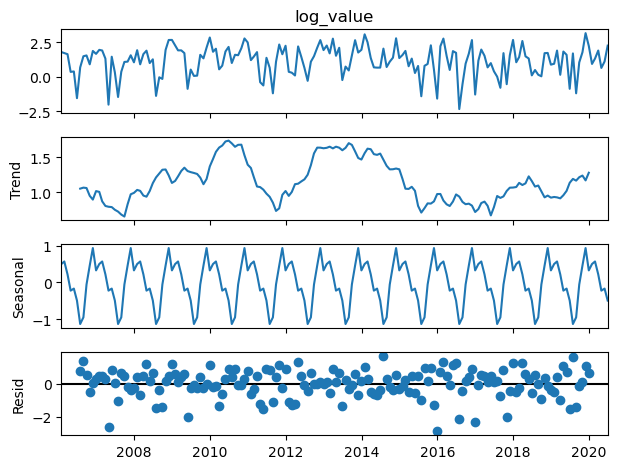

In [12]:
# 1. Aplicar la transformación logarítmica

# 2. Reemplazar los valores infinitos con NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Eliminar o rellenar los valores NaN
# Opción A: Eliminar las filas con NaN
df_cleaned = df.dropna(subset=['log_value'])

# Opción B: Rellenar con interpolación lineal
#df['log_value'].interpolate(method='linear', inplace=True)

# 4. Ahora puedes ejecutar la descomposición en el DataFrame limpio
# Usando la Opción A:
decomposition = seasonal_decompose(df_cleaned['log_value'], model='additive', period=12)

# O usando la Opción B:
#decomposition = seasonal_decompose(df['log_value'], model='additive', period=12)

decomposition.plot()
plt.show()

Análisis de Tendencia y Volatilidad por Segmento:

--- Segmento 1 ---
Fechas: 2006-01-31 a 2020-06-30
Media (Nivel): 4.96
Desviación Estándar (Volatilidad): 4.35
Cambio en la Tendencia: 3.58



/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_80943/1875722769.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(segments))


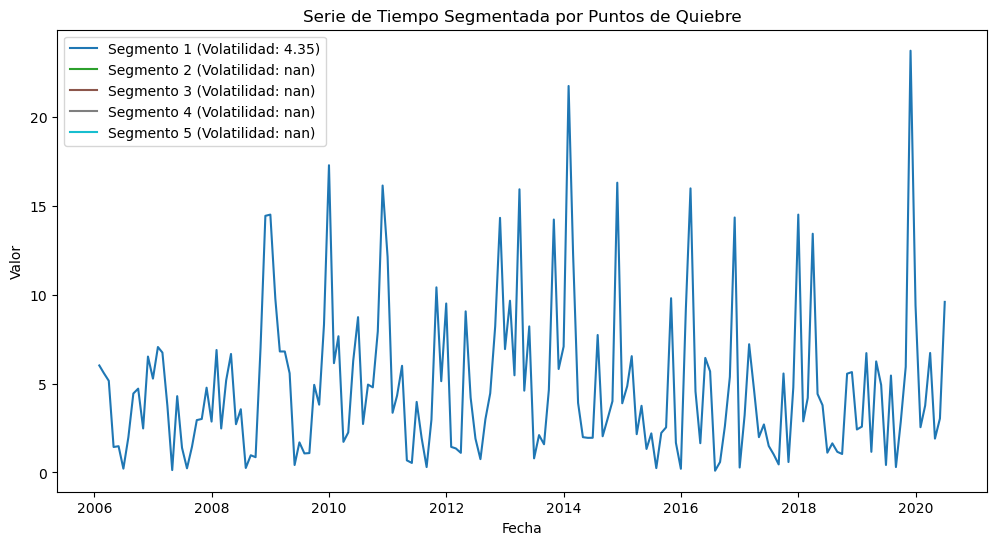

In [13]:
# Asume que 'df_cleaned' es tu DataFrame con la serie de tiempo ya limpia,
# ordenada y con el índice de fechas, y 'result' es la lista de índices
# de los puntos de quiebre del algoritmo ruptures.
# Ejemplo: df_cleaned['Value'] es la columna de valores

# --- 1. Definir los segmentos con los puntos de quiebre ---
break_points = [0] + result[:-1] + [len(df_cleaned)]
segments = []

for i in range(len(break_points) - 1):
    start = break_points[i]
    end = break_points[i+1]
    segments.append(df_cleaned.iloc[start:end])

# --- 2. Analizar la tendencia y volatilidad de cada segmento ---
print("Análisis de Tendencia y Volatilidad por Segmento:\n")
for i, segment in enumerate(segments):
    if segment.empty:
        continue
    
    # Calcular la media y la desviación estándar para la variabilidad
    mean_val = segment['Value'].mean()
    std_dev_val = segment['Value'].std()
    
    # Analizar la tendencia (puedes usar regresión lineal para una mejor estimación)
    trend = segment['Value'].iloc[-1] - segment['Value'].iloc[0]
    
    print(f"--- Segmento {i+1} ---")
    print(f"Fechas: {segment.index.min().strftime('%Y-%m-%d')} a {segment.index.max().strftime('%Y-%m-%d')}")
    print(f"Media (Nivel): {mean_val:.2f}")
    print(f"Desviación Estándar (Volatilidad): {std_dev_val:.2f}")
    print(f"Cambio en la Tendencia: {trend:.2f}\n")

# --- 3. Visualizar los segmentos con sus propiedades ---
plt.figure(figsize=(12, 6))
colors = plt.cm.get_cmap('tab10', len(segments))

for i, segment in enumerate(segments):
    plt.plot(segment.index, segment['Value'], color=colors(i), 
             label=f'Segmento {i+1} (Volatilidad: {segment["Value"].std():.2f})')

plt.title('Serie de Tiempo Segmentada por Puntos de Quiebre')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [14]:
df_cleaned.head()

,was_nan,Value,Medition_Types,Location,log_value
Date,,,,,
2006-01-31,1.0,6.025806,1.0,1.0,1.796051
2006-02-28,1.0,5.600000,1.0,1.0,1.722767
2006-03-31,1.0,5.161290,1.0,1.0,1.641187
2006-04-30,1.0,1.433333,1.0,1.0,0.360003
2006-05-31,1.0,1.477419,1.0,1.0,0.390297


/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_80943/3515852753.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['diff_estacional'] = df_cleaned['log_value'].diff(periods=12)


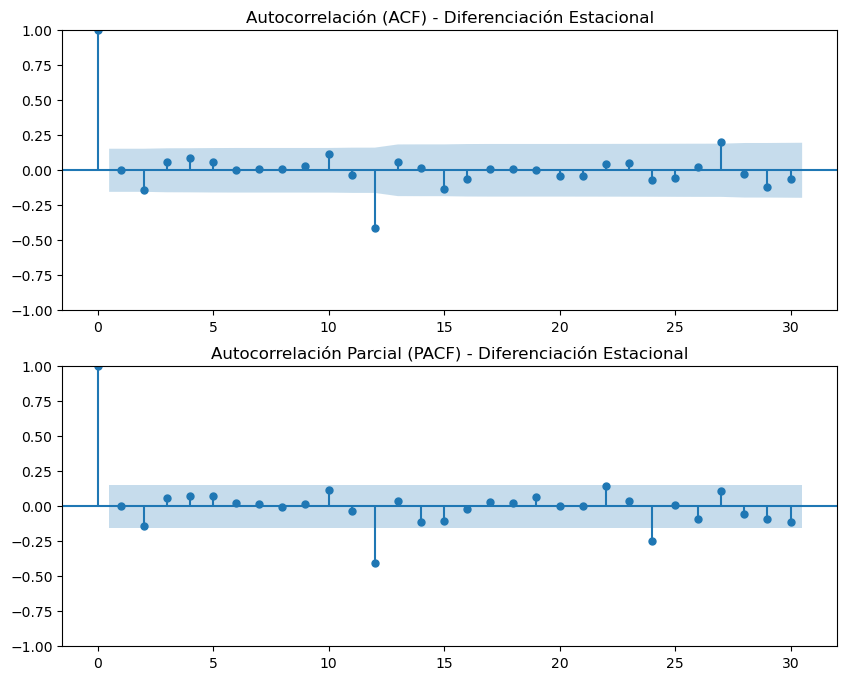

In [15]:
# Suponiendo que 'df' es tu DataFrame limpio con la columna 'log_value'

# Diferenciación estacional
df_cleaned['diff_estacional'] = df_cleaned['log_value'].diff(periods=12)

# Eliminar los NaN resultantes de la diferenciación
df_diff_estacional_cleaned = df_cleaned.dropna(subset=['diff_estacional'])

# Ahora puedes usar df_diff_estacional_cleaned para graficar
# la autocorrelación (ACF) y autocorrelación parcial (PACF).

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_diff_estacional_cleaned['diff_estacional'], ax=ax1, lags=30)
plot_pacf(df_diff_estacional_cleaned['diff_estacional'], ax=ax2, lags=30)
ax1.set_title('Autocorrelación (ACF) - Diferenciación Estacional')
ax2.set_title('Autocorrelación Parcial (PACF) - Diferenciación Estacional')
plt.show()

# 6. Entrenar modelo SARIMA.

In [16]:
df_cleaned.sort_index(inplace=True)
print(df_cleaned)

             was_nan     Value  Medition_Types  Location  log_value  \
Date                                                                  
2006-01-31  1.000000  6.025806             1.0       1.0   1.796051   
2006-02-28  1.000000  5.600000             1.0       1.0   1.722767   
2006-03-31  1.000000  5.161290             1.0       1.0   1.641187   
2006-04-30  1.000000  1.433333             1.0       1.0   0.360003   
2006-05-31  1.000000  1.477419             1.0       1.0   0.390297   
...              ...       ...             ...       ...        ...   
2020-02-29  0.000000  3.765517             1.0       1.0   1.325885   
2020-03-31  0.096774  6.729032             1.0       1.0   1.906431   
2020-04-30  0.033333  1.906667             1.0       1.0   0.645357   
2020-05-31  0.032258  3.038710             1.0       1.0   1.111433   
2020-06-30  0.033333  9.606667             1.0       1.0   2.262457   

            diff_estacional  
Date                         
2006-01-31      

In [17]:

# Entrena el modelo SARIMA con los parámetros identificados
print("Entrenando modelo SARIMA(1,0,1)(1,1,1,12)...")

# Asegúrate de usar la serie original transformada ('log_value') para el modelo
# La diferenciación se realiza internamente en el modelo SARIMA
model = SARIMAX(df_cleaned['log_value'], 
                order=(1, 0, 1), 
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit()

# Muestra el resumen del modelo entrenado
print(results.summary())

Entrenando modelo SARIMA(1,0,1)(1,1,1,12)...
                                     SARIMAX Results                                      
Dep. Variable:                          log_value   No. Observations:                  174
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -211.166
Date:                            Sat, 23 Aug 2025   AIC                            432.333
Time:                                    06:57:58   BIC                            447.319
Sample:                                01-31-2006   HQIC                           438.421
                                     - 06-30-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8388      0.141     -5.949      0.000      -1.115   

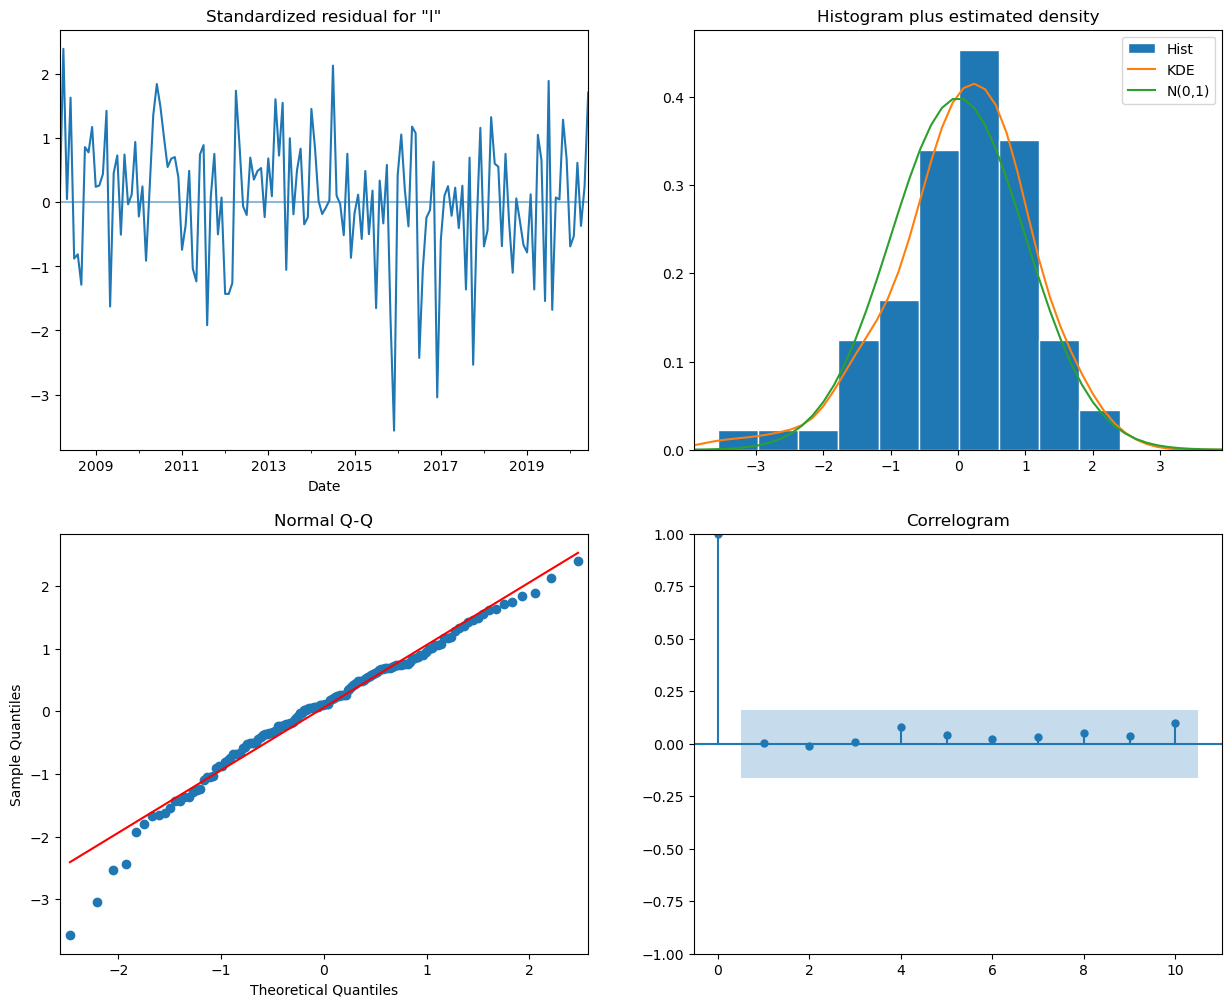

In [18]:
# Muestra los gráficos de diagnóstico del modelo
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### Prueba de Dickey-Fuller (Dickey-Fuller test).

In [19]:
df_cleaned['log_value']

Date
2006-01-31    1.796051
2006-02-28    1.722767
2006-03-31    1.641187
2006-04-30    0.360003
2006-05-31    0.390297
                ...   
2020-02-29    1.325885
2020-03-31    1.906431
2020-04-30    0.645357
2020-05-31    1.111433
2020-06-30    2.262457
Freq: ME, Name: log_value, Length: 174, dtype: float64

In [20]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df_cleaned['log_value'])

Resultados de la prueba de Dickey-Fuller:


Test Statistic                  -2.097353
p-value                          0.245580
#Lags Used                      12.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64

# 7. Predicción del modelo. 

In [21]:
df_cleaned = df.loc['2005-01-01':]
df_cleaned.head()

,was_nan,Value,Medition_Types,Location,log_value
Date,,,,,
2005-01-31,1.0,0.0,1.0,1.0,NaN
2005-02-28,1.0,0.0,1.0,1.0,NaN
2005-03-31,1.0,0.0,1.0,1.0,NaN
2005-04-30,1.0,0.0,1.0,1.0,NaN
2005-05-31,1.0,0.0,1.0,1.0,NaN


In [22]:
mean_value = df_cleaned['log_value'].mean()
df_cleaned['log_value'] = df_cleaned['log_value'].fillna(mean_value)

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_80943/257538234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['log_value'] = df_cleaned['log_value'].fillna(mean_value)


In [23]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 186 entries, 2005-01-31 to 2020-06-30
Freq: ME
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   was_nan         186 non-null    float64
 1   Value           186 non-null    float64
 2   Medition_Types  186 non-null    float64
 3   Location        186 non-null    float64
 4   log_value       186 non-null    float64
dtypes: float64(5)
memory usage: 8.7 KB


In [24]:
df_cleaned.head()

,was_nan,Value,Medition_Types,Location,log_value
Date,,,,,
2005-01-31,1.0,0.0,1.0,1.0,1.161404
2005-02-28,1.0,0.0,1.0,1.0,1.161404
2005-03-31,1.0,0.0,1.0,1.0,1.161404
2005-04-30,1.0,0.0,1.0,1.0,1.161404
2005-05-31,1.0,0.0,1.0,1.0,1.161404


In [25]:
#df_cleaned = df.loc['2005-01-01':]
split_date = '2019-01-01'

# Create the training set
train_data = df_cleaned['log_value'].loc[:split_date]

# Create the test set
test_data = df_cleaned['log_value'].loc[split_date:]

In [26]:
# 1. Define your training data
train_data = df_cleaned['log_value'][:'2018-12-31']

# 2. Find the last date of the training data. This will be the prediction start.
last_train_date = train_data.index[-1]

# 3. Find the first date of the test data. This is what you want to predict.
first_test_date = test_data.index[0]

# 4. Use the correct start and end for your prediction
# You can predict by steps or by a specific date range.

# Method 1: Predict by steps (Recommended)
forecast_steps = len(test_data)
forecast_result = results.get_forecast(steps=forecast_steps)

# Method 2: Predict by date range
# Make sure the start date is correct and the end date is after it.
#forecast_result = results.get_forecast(start=first_test_date, end=test_data.index[-1])

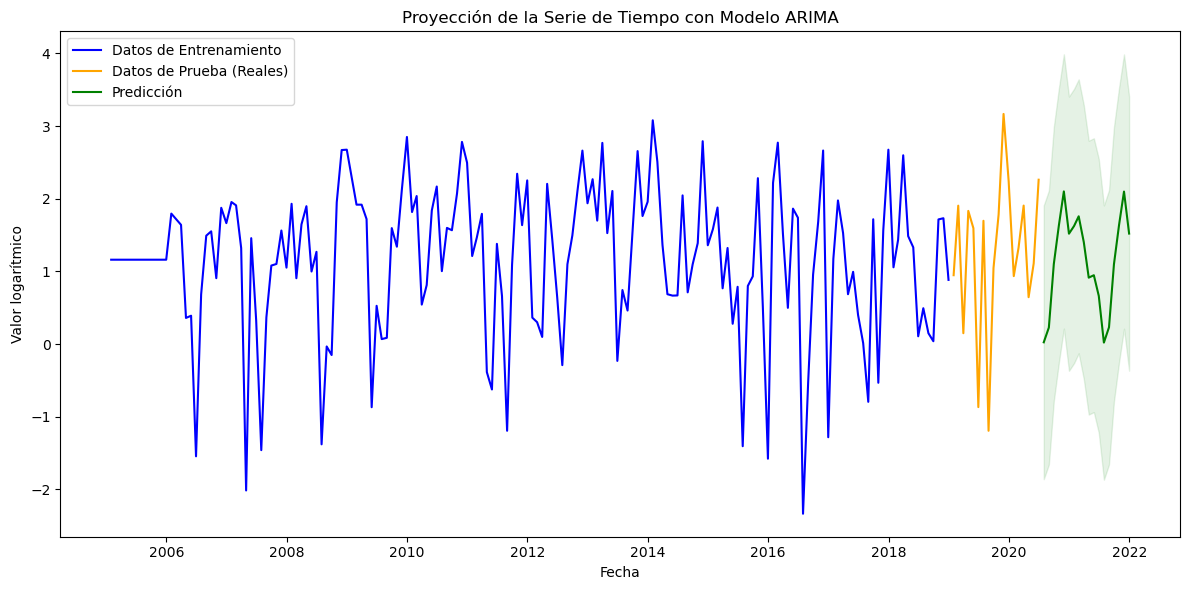

In [27]:
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int() # Intervalo de confianza

# --- Sección de visualización (la parte nueva) ---

plt.figure(figsize=(12, 6))

# Graficar los datos de entrenamiento para ver la historia
sns.lineplot(data=train_data, label='Datos de Entrenamiento', color='blue')

# Graficar los datos reales del conjunto de prueba
sns.lineplot(data=test_data, label='Datos de Prueba (Reales)', color='orange')

# Graficar la predicción
sns.lineplot(x=forecast_mean.index, y=forecast_mean, color='green', label='Predicción')

# Opcional: sombrear el área del intervalo de confianza para ver la incertidumbre del pronóstico
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.1)

plt.title('Proyección de la Serie de Tiempo con Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor logarítmico')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Suponiendo que tu DataFrame df_cleaned tiene un índice de fechas
# y ya está ordenado cronológicamente.

# 1. Encuentra la fecha más antigua y la más reciente en tus datos
start_date = df_cleaned.index.min()
end_date = df_cleaned.index.max()

print(f"La serie de tiempo completa abarca desde {start_date.date()} hasta {end_date.date()}")

# 2. Define una fecha de corte para la división
# Se recomienda usar el 80% de los datos para entrenamiento y el 20% para prueba.
# En este caso, usaremos el 1 de enero de 2018 como fecha de corte.
split_date = '2018-01-01'

# 3. Divide los datos en conjuntos de entrenamiento y prueba
train_data = df_cleaned['log_value'].loc[:split_date]
test_data = df_cleaned['log_value'].loc[split_date:]

print(f"El conjunto de entrenamiento termina en: {train_data.index.max().date()}")
print(f"El conjunto de prueba comienza en: {test_data.index.min().date()}")

# Ahora, cuando grafiques, los dos conjuntos de datos se verán contiguos.

La serie de tiempo completa abarca desde 2005-01-31 hasta 2020-06-30
El conjunto de entrenamiento termina en: 2017-12-31
El conjunto de prueba comienza en: 2018-01-31


In [29]:
# 1. Definir el número de pasos de predicción.
# En este caso, el número de observaciones en tu conjunto de prueba.
forecast_steps = len(test_data)

# 2. Generar la predicción.
# 'fitted_model' es el objeto del modelo que ya ha sido entrenado.
forecast_result = results.get_forecast(steps=forecast_steps)

# La predicción y el intervalo de confianza se encuentran dentro de este objeto.
# Puedes acceder a ellos de esta manera:
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

print("Predicción de los próximos pasos:")
print(forecast_mean)

Predicción de los próximos pasos:
2020-07-31    0.024548
2020-08-31    0.227528
2020-09-30    1.101113
2020-10-31    1.637225
2020-11-30    2.101128
2020-12-31    1.519486
2021-01-31    1.625474
2021-02-28    1.758695
2021-03-31    1.403462
2021-04-30    0.914348
2021-05-31    0.948001
2021-06-30    0.663060
2021-07-31    0.020561
2021-08-31    0.230872
2021-09-30    1.098309
2021-10-31    1.639576
2021-11-30    2.099155
2021-12-31    1.521140
2022-01-31    1.624087
2022-02-28    1.759859
2022-03-31    1.402486
2022-04-30    0.915167
2022-05-31    0.947314
2022-06-30    0.663635
2022-07-31    0.020078
2022-08-31    0.231277
2022-09-30    1.097969
2022-10-31    1.639861
2022-11-30    2.098916
2022-12-31    1.521340
Freq: ME, Name: predicted_mean, dtype: float64


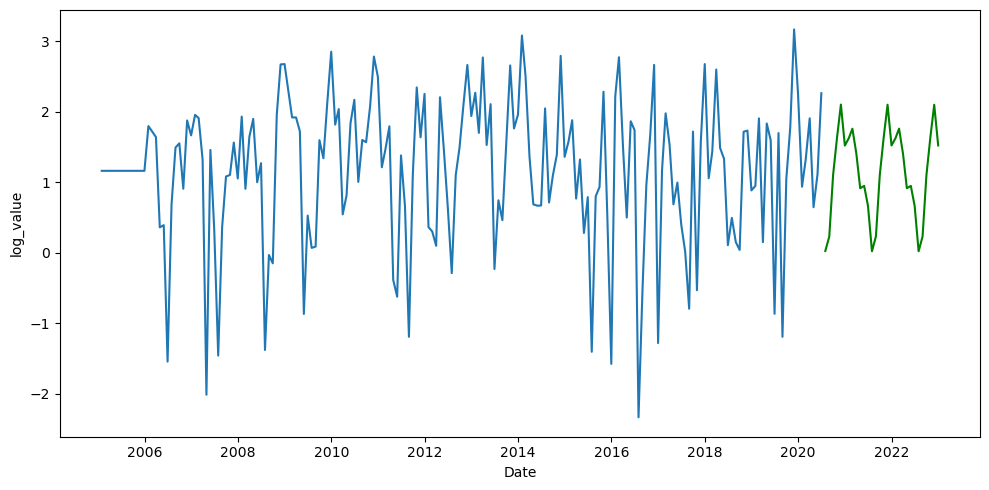

In [30]:
fig, axis = plt.subplots(figsize=(10, 5))

# Trazar la serie de tiempo original
sns.lineplot(data=df_cleaned['log_value'])

# Trazar la predicción usando el atributo .predicted_mean del objeto
sns.lineplot(data=forecast_result.predicted_mean, color="green")

plt.tight_layout()
plt.show()

# 8. Guardar Modelos. 

In [31]:
# --- Guardar el modelo ---
filename = '../models/aquifers/aquifers_prediction_model.pkl'

# Guarda el modelo en el archivo
joblib.dump(results, filename)

print(f"El modelo ha sido guardado en el archivo: {filename}")

El modelo ha sido guardado en el archivo: ../models/aquifers/aquifers_prediction_model.pkl
